**This notebook contains followings:**
* Data Merging
* Deep Surv


In [1]:
import os
os.getcwd()


'c:\\Users\\User\\Desktop\\UNI\\MasterThesis\\maintenance prediction'

In [2]:
import matplotlib.pyplot as plt

 62%|██████▎   | 25/40 [00:00<00:00, 68.85it/s]


CPH model: 0.6610169491525424/0.14252239201019404
RSF model: 0.7457627118644068/0.07213299200170564
Boost model: 0.8135593220338984/0.06625761577902334
BoostD model: 0.6101694915254238/0.1280357574929299
SVM model: 0.3898305084745763/NA
NN model: 0.8433169475481137/0.1497080200269519


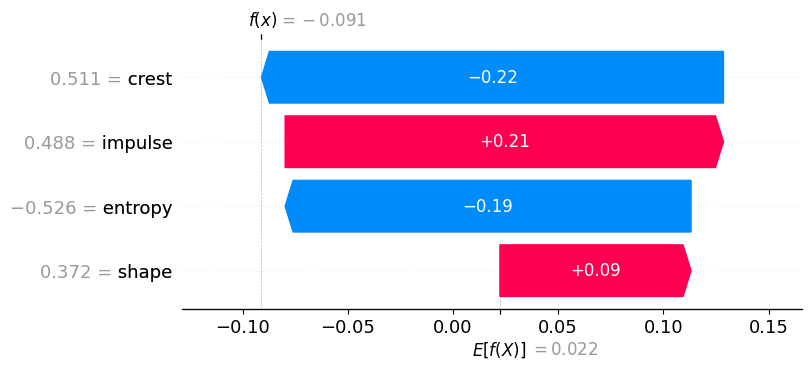

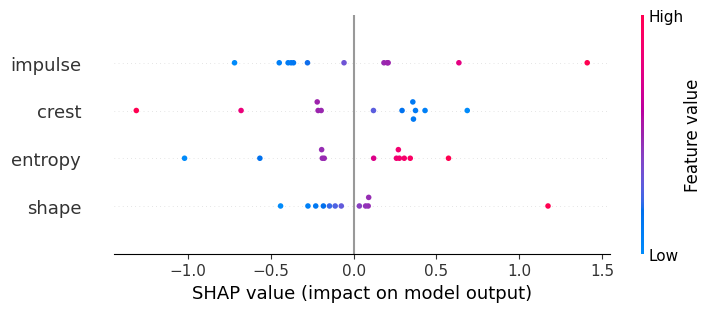

In [5]:
import sys
sys.path.append('c:\\Users\\User\\Desktop\\UNI\\MasterThesis\\maintenance prediction\\src')
import numpy as np
import pandas as pd
import math
import shap
from pathlib import Path
import config as cfg
from xgbse.non_parametric import calculate_kaplan_vectorized
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.feature_selectors import SelectKBest4, UMAP12
from tools import regressors
from xgbse.metrics import approx_brier_score
from sksurv.metrics import concordance_index_censored
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
from auton_survival.metrics import survival_regression_metric
import pandas as pd
from utility.event import Event

N_BOOT = 2


data_util = DataETL()
survival= Survival()

cov, boot, info_pack = FileReader().read_data_xjtu()
X, y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=0)
S1, S2 = (X_train, y_train), (X_test, y_test)

set_tr, set_te, set_tr_NN, set_te_NN = data_util.format_main_data(S1, S2)
set_tr, set_te, set_tr_NN, set_te_NN = data_util.centering_main_data(set_tr, set_te, set_tr_NN, set_te_NN)

X_train = set_tr [0]
y_train = set_tr [1]
X_test = set_te [0]
y_test = set_te[1]
X_train_NN = set_tr_NN [0]
y_train_NN = set_tr_NN [1]
X_test_NN = set_te_NN [0]
y_test_NN = set_te_NN [1]


X_test_NN, y_test_NN = data_util.control_censored_data(X_test_NN, y_test_NN, percentage= 10)

lower, upper = np.percentile(y['Survival_time'], [10, 90])
time_bins = np.arange(int(lower), int(upper))
lower_NN, upper_NN = np.percentile(y_test[y_test.dtype.names[1]], [10, 90])
times = np.arange(np.ceil(lower_NN), np.floor(upper_NN)).tolist()

cph_model = regressors.Cph.make_model(regressors.Cph().get_best_params())
rsf_model = regressors.RSF.make_model(regressors.RSF().get_best_params())
boost_model = regressors.GradientBoosting.make_model(regressors.GradientBoosting().get_best_params())
boostD_model = regressors.GradientBoostingDART.make_model(regressors.GradientBoostingDART().get_best_params())
SVM_model = regressors.SVM.make_model(regressors.SVM().get_best_params())
NN_model = regressors.DeepSurv().make_model()
NN_params= regressors.DeepSurv().get_best_hyperparams()

best_features = SelectKBest4(X_train, y_train, boost_model).get_features()
X_train, X_test, X_train_NN, X_test_NN = X_train.loc[:,best_features], X_test.loc[:,best_features], X_train_NN.loc[:,best_features], X_test_NN.loc[:,best_features]

x= X_train_NN.to_numpy()
t= y_train_NN.loc[:,"time"].to_numpy()
e= y_train_NN.loc[:,"event"].to_numpy()

cph_model.fit(X_train, y_train)
rsf_model.fit(X_train, y_train)
boost_model.fit(X_train, y_train)
boostD_model.fit(X_train, y_train)
SVM_model.fit(X_train, y_train)
NN_model.fit(x, t, e, vsize=0.2, iters= 40, **NN_params)

cph_surv_func = survival.predict_survival_function(cph_model, X_test, y_test, lower, upper)
rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, y_test, lower, upper)
boost_surv_func = survival.predict_survival_function(boost_model, X_test, y_test, lower, upper)
boostD_surv_func = survival.predict_survival_function(boostD_model, X_test, y_test, lower, upper)
x= X_test_NN.to_numpy()
NN_surv_func = NN_model.predict_survival(x, times)

cph_hazard_func = survival.predict_hazard_function(cph_model, X_test, y_test, lower, upper)
rsf_hazard_func = survival.predict_hazard_function(rsf_model, X_test, y_test, lower, upper)
boost_hazard_func = survival.predict_hazard_function(boost_model, X_test, y_test, lower, upper)
boostD_hzazard_func = survival.predict_hazard_function(boostD_model, X_test, y_test, lower, upper)
NN_hazard_func = NN_model.predict_risk(x, times)

km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Event'].reshape(1,-1),
                                                        y_test['Survival_time'].reshape(1,-1),
                                                        time_bins)

# Calculate test results
cph_c_index = concordance_index_censored(y_test['Event'], y_test['Survival_time'],
                                            cph_model.predict(X_test))[0]
rsf_c_index = concordance_index_censored(y_test['Event'], y_test['Survival_time'],
                                            rsf_model.predict(X_test))[0]
boost_c_index = concordance_index_censored(y_test['Event'], y_test['Survival_time'],
                                            boost_model.predict(X_test))[0]
boostD_c_index = concordance_index_censored(y_test['Event'], y_test['Survival_time'],
                                            boostD_model.predict(X_test))[0]
SVM_c_index = concordance_index_censored(y_test['Event'], y_test['Survival_time'],
                                            SVM_model.predict(X_test))[0]
NN_c_index = np.mean(survival_regression_metric('ctd', y_test_NN,
                                                NN_surv_func,
                                                times=times))

# CPH BS
cph_surv_probs = pd.DataFrame(np.row_stack([fn(time_bins) for fn in cph_model.predict_survival_function(X_test)]))
cph_bs = approx_brier_score(y_test, cph_surv_probs)

# RSF BS
rsf_surv_probs = pd.DataFrame(np.row_stack([fn(time_bins) for fn in rsf_model.predict_survival_function(X_test)]))
rsf_bs = approx_brier_score(y_test, rsf_surv_probs)

# Boost BS
boost_surv_probs = pd.DataFrame(np.row_stack([fn(time_bins) for fn in boost_model.predict_survival_function(X_test)]))
boost_bs = approx_brier_score(y_test, boost_surv_probs)

# BoostD BS
boostD_surv_probs = pd.DataFrame(np.row_stack([fn(time_bins) for fn in boostD_model.predict_survival_function(X_test)]))
boostD_bs = approx_brier_score(y_test, boostD_surv_probs)

# NN BS
NN_bs = np.mean(survival_regression_metric('brs', y_test_NN,
                                                NN_surv_func,
                                                times=times))

print(f"CPH model: {cph_c_index}/{cph_bs}")
print(f"RSF model: {rsf_c_index}/{rsf_bs}")
print(f"Boost model: {boost_c_index}/{boost_bs}")
print(f"BoostD model: {boostD_c_index}/{boostD_bs}")
print(f"SVM model: {SVM_c_index}/NA")
print(f"NN model: {NN_c_index}/{NN_bs}")

shap_pack= []

# Make SHAP values

explainer_CPH = shap.Explainer(cph_model.predict, X_test)
shap_values_CPH = explainer_CPH(X_test)

explainer_RSF = shap.Explainer(rsf_model.predict, X_test)
shap_values_RSF = explainer_RSF(X_test)

explainer_B = shap.Explainer(boost_model.predict, X_test)
shap_values_B = explainer_B(X_test)

explainer_BD = shap.Explainer(boostD_model.predict, X_test)
shap_values_BD = explainer_BD(X_test)

explainer_NN = shap.Explainer(NN_model.predict_survival, X_test)
shap_values_NN = explainer_NN(X_test)

shap.plots.waterfall(shap_values_CPH[0])
shap.plots.beeswarm(shap_values_CPH)

In [87]:
shap_values_NN2 = shap_values_NN
explainer_NN2= explainer_NN

print(shap_values_NN2)
print(explainer_NN2)

.values =
array([[ 1.42101552e-03,  3.30886443e-03,  1.60565266e-02,
         2.26900309e-03],
       [ 9.50100299e-04,  3.15376201e-03,  1.74949940e-02,
         2.36433306e-03],
       [-7.61492998e-03, -4.95348421e-03,  2.14915014e-03,
        -7.61062670e-05],
       [ 3.23558567e-02,  8.02085503e-03, -1.29989662e-01,
        -1.86334472e-02],
       [ 1.53913261e-02,  1.01327973e-02,  2.06229196e-02,
         5.94358651e-03],
       [-6.13815065e-03, -2.61617074e-03,  2.01534644e-02,
         2.31672859e-03],
       [-6.29071068e-03, -1.10414455e-03,  2.30534629e-02,
         2.39150918e-03],
       [-6.48774919e-03, -3.14893390e-03,  1.70438078e-02,
         1.71348946e-03],
       [ 1.27163454e-03,  3.24491298e-03,  1.62844675e-02,
         2.26032571e-03],
       [-7.67019862e-03, -3.65503228e-03,  8.52281657e-03,
         1.25256622e-03],
       [-7.69041107e-03, -2.50920888e-03,  1.41929609e-02,
         2.19323045e-03],
       [-9.49778219e-03, -9.87421746e-03, -2.55849091e-

In [62]:
print (NN_model.predict_survival)

<bound method DeepCoxPH.predict_survival of <auton_survival.models.cph.DeepCoxPH object at 0x000001DC28E47F10>>


In [88]:
#shap_values_NN2[0].values = shap_values_NN2[0].values[0][0]
print (shap_values_NN2)

.values =
array([[ 1.42101552e-03,  3.30886443e-03,  1.60565266e-02,
         2.26900309e-03],
       [ 9.50100299e-04,  3.15376201e-03,  1.74949940e-02,
         2.36433306e-03],
       [-7.61492998e-03, -4.95348421e-03,  2.14915014e-03,
        -7.61062670e-05],
       [ 3.23558567e-02,  8.02085503e-03, -1.29989662e-01,
        -1.86334472e-02],
       [ 1.53913261e-02,  1.01327973e-02,  2.06229196e-02,
         5.94358651e-03],
       [-6.13815065e-03, -2.61617074e-03,  2.01534644e-02,
         2.31672859e-03],
       [-6.29071068e-03, -1.10414455e-03,  2.30534629e-02,
         2.39150918e-03],
       [-6.48774919e-03, -3.14893390e-03,  1.70438078e-02,
         1.71348946e-03],
       [ 1.27163454e-03,  3.24491298e-03,  1.62844675e-02,
         2.26032571e-03],
       [-7.67019862e-03, -3.65503228e-03,  8.52281657e-03,
         1.25256622e-03],
       [-7.69041107e-03, -2.50920888e-03,  1.41929609e-02,
         2.19323045e-03],
       [-9.49778219e-03, -9.87421746e-03, -2.55849091e-

In [90]:
print(shap_values_CPH)

.values =
array([[-0.19305183, -0.21973112,  0.09089768,  0.20847231],
       [-0.17741275, -0.19593097,  0.07243202,  0.18322503],
       [ 0.34184538,  0.43105695, -0.27575516, -0.44894958],
       [-1.02051867, -1.31168964,  1.17339565,  1.41000866],
       [-0.5658751 , -0.6793538 ,  0.03461513,  0.63546607],
       [ 0.25844758,  0.35734612, -0.11125092, -0.37756681],
       [ 0.12088048,  0.11978959, -0.07442028, -0.05792003],
       [ 0.27612989,  0.37344362, -0.14563471, -0.39534404],
       [-0.18895498, -0.2143042 ,  0.08789639,  0.2029059 ],
       [ 0.30567146,  0.36115199, -0.22875928, -0.36305218],
       [ 0.27008098,  0.29237453, -0.18252139, -0.27854022],
       [ 0.57275757,  0.68584694, -0.44089513, -0.71870511]])

.base_values =
array([0.02226299, 0.02226299, 0.02226299, 0.02226299, 0.02226299,
       0.02226299, 0.02226299, 0.02226299, 0.02226299, 0.02226299,
       0.02226299, 0.02226299])

.data =
array([[-5.25985170e-01,  5.11347668e-01,  3.72183677e-01,
       

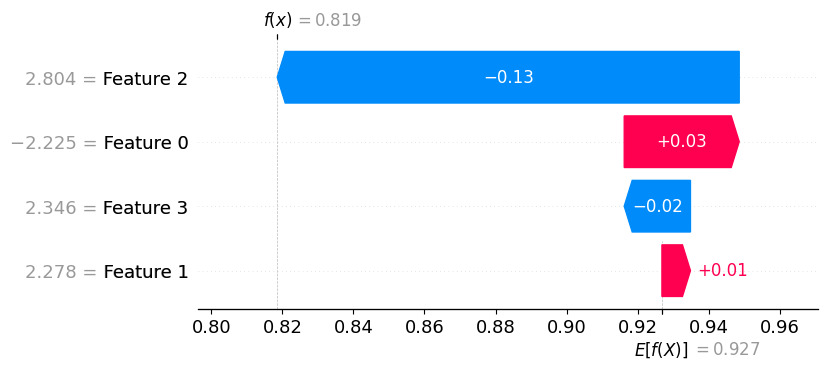

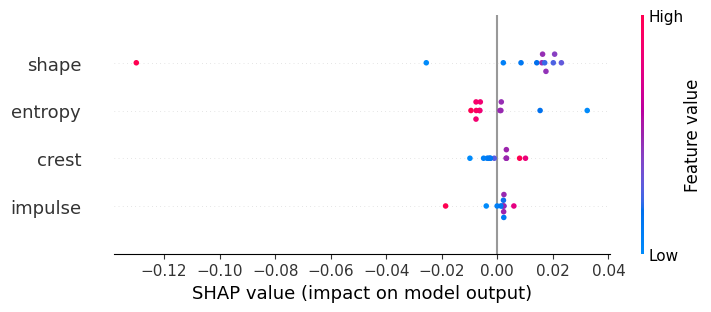

In [103]:
idx = 3
exp = shap.Explanation(shap_values_NN.values, shap_values_NN.base_values[0], shap_values_NN.data)
shap.plots.waterfall(exp[idx])                  
shap.plots.beeswarm(shap_values_NN)

In [95]:
n_censored = y.shape[0] - y["Event"].sum()
print ("There are {} samples censored", n_censored)
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

There are {} samples censored 10
25.0% of records are censored


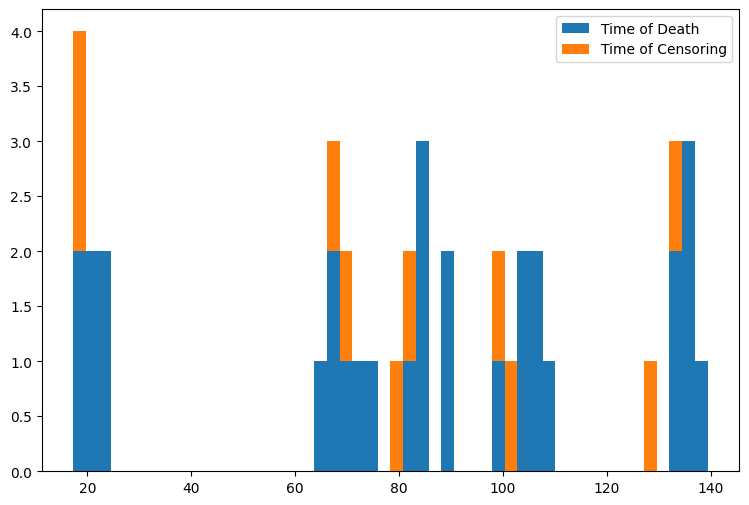

In [28]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_time"][y["Event"]],
                               y["Survival_time"][~y["Event"]]),
                              bins=50, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [7]:
data_util = DataETL()
survival= Survival()

cov, boot, info_pack = FileReader().read_data_xjtu()
X, y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT)

X2 = X.iloc[:,:-2]

# UMAP

In [8]:
import umap.plot
import umap

In [9]:
mapper = umap.UMAP(n_neighbors=10, min_dist=0.2).fit(X2) 

<Axes: >

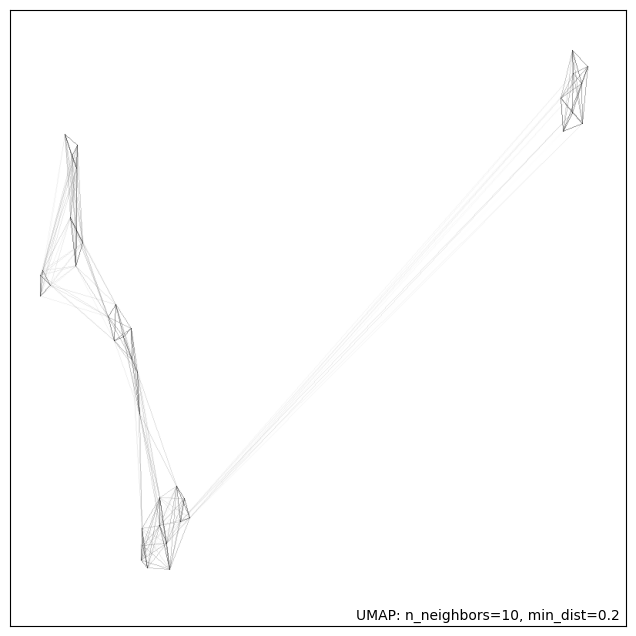

In [10]:
umap.plot.connectivity(mapper, show_points=True)

<Axes: >

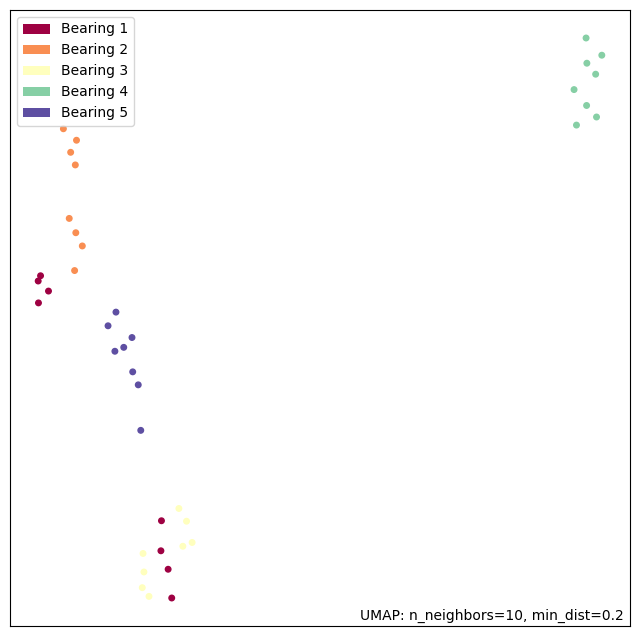

In [11]:
labels= pd.DataFrame(["Bearing 1", "Bearing 1", "Bearing 1", "Bearing 1", "Bearing 1", "Bearing 1", "Bearing 1", "Bearing 1", 
              "Bearing 2", "Bearing 2", "Bearing 2", "Bearing 2", "Bearing 2", "Bearing 2", "Bearing 2", "Bearing 2",
              "Bearing 3", "Bearing 3", "Bearing 3", "Bearing 3", "Bearing 3", "Bearing 3", "Bearing 3", "Bearing 3",
              "Bearing 4", "Bearing 4", "Bearing 4", "Bearing 4", "Bearing 4", "Bearing 4", "Bearing 4", "Bearing 4",   
              "Bearing 5", "Bearing 5", "Bearing 5", "Bearing 5", "Bearing 5", "Bearing 5", "Bearing 5", "Bearing 5"],
              columns= ["Labels"])
umap.plot.points(mapper, labels= labels["Labels"])

# Plotly distributions

In [ ]:
import plotly.figure_factory as ff

# Add histogram data
x1 = np.random.randn(200) - 2
x2 = np.random.randn(200)
x3 = np.random.randn(200) + 2
x4 = np.random.randn(200) + 4

# Group data together
hist_data = [x1, x2, x3, x4]

group_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

# Multicollinearity

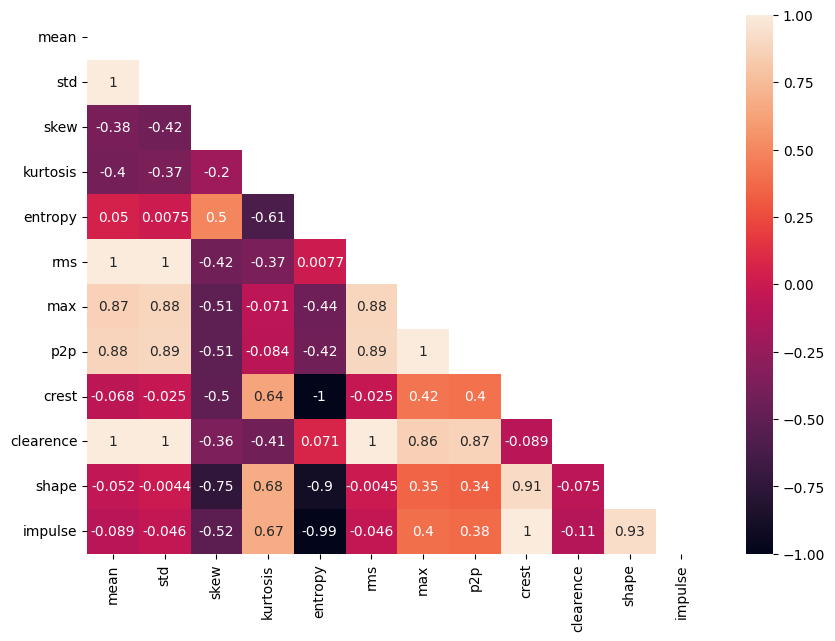

In [113]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(X2.corr(), dtype=bool))

# generate heatmap
sns.heatmap(X2.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
#plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [14]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = X2[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [102]:

# features to consider removing
considered_features = X2.columns
considered_features =  ['p2p', 'max', 'clearence', 'mean', 'std', 'rms', 'crest', 'impulse', 'entropy','shape', 'kurtosis', 'skew']

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,mean,1.876442e+07
4,std,1.234880e+07
2,clearence,7.102263e+06
5,rms,5.675956e+06
6,crest,2.235090e+05
7,impulse,1.991089e+05
1,max,2.829667e+04
0,p2p,2.674662e+04
8,entropy,6.480035e+03
9,shape,1.712910e+03


In [48]:
def select_features_with_vif(data, k= 8):
    # Create a DataFrame to store the VIF results
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns

    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

    vif_data = vif_data.sort_values(by="VIF").reset_index(drop=True) 
    selected_features = vif_data.iloc[:k, :1]

    return selected_features["Feature"].values.tolist()


In [49]:
result= select_features_with_vif(X2)
print (result)

['skew', 'kurtosis', 'p2p', 'max', 'entropy', 'shape', 'crest', 'impulse']


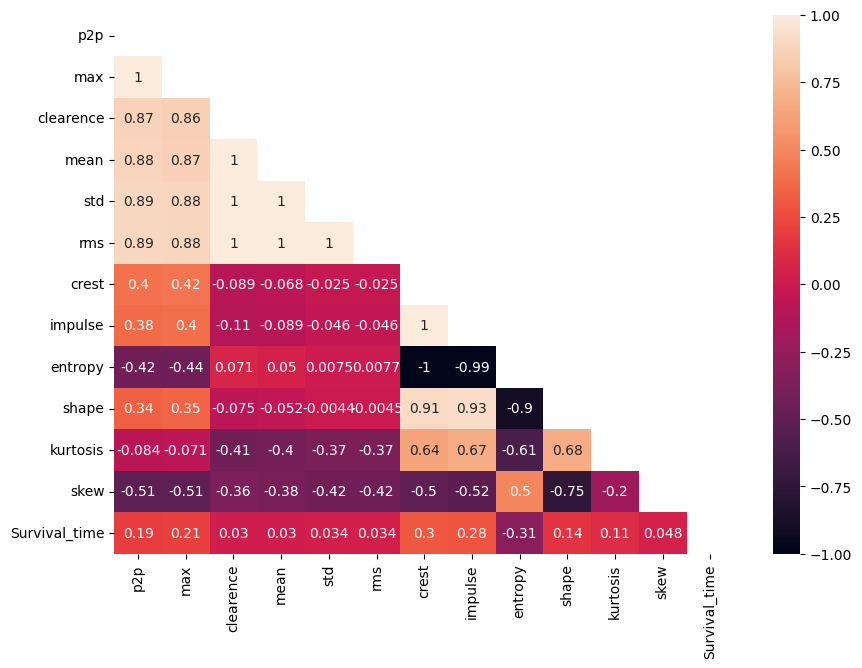

In [121]:
# set figure size
plt.figure(figsize=(10,7))

X3= X.loc[:, ['p2p', 'max', 'clearence', 'mean', 'std', 'rms', 'crest', 'impulse', 'entropy','shape', 'kurtosis', 'skew', 'Survival_time']]

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(X3.corr(), dtype=bool))

# generate heatmap
sns.heatmap(X3.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
#plt.title('Correlation coefficient of predictors in relation with time of surival')
plt.show()

In [116]:
# load statmodels functions
import dcor

# compute the distance for all given features
def compute_distance(considered_features):
    
    X = X2[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store distence values
    dist = pd.DataFrame()
    dist["Variable"] = X.columns
    dist["Distance"] = [dcor.distance_correlation(X2.values[0], i) for i in range(X2.values.shape[1])]
    dist = dist[dist['Variable']!='intercept']
    return dist

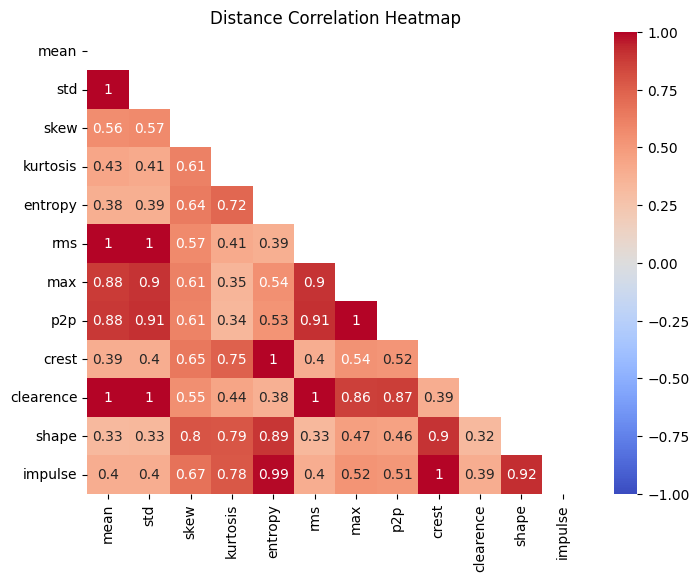

In [119]:
# Compute distance correlation matrix
correlation_matrix = np.zeros((len(X2.columns), len(X2.columns)))
for i in range(len(X2.columns)):
    for j in range(i+1, len(X2.columns)):
        feature1 = X2.iloc[:, i].values.reshape(-1, 1)
        feature2 = X2.iloc[:, j].values.reshape(-1, 1)
        NLcor = dcor.distance_correlation(feature1, feature2)
        correlation_matrix[i, j] = NLcor
        correlation_matrix[j, i] = NLcor

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1,
            xticklabels=X2.columns, yticklabels=X2.columns)
plt.title('Distance Correlation Heatmap')
plt.show()

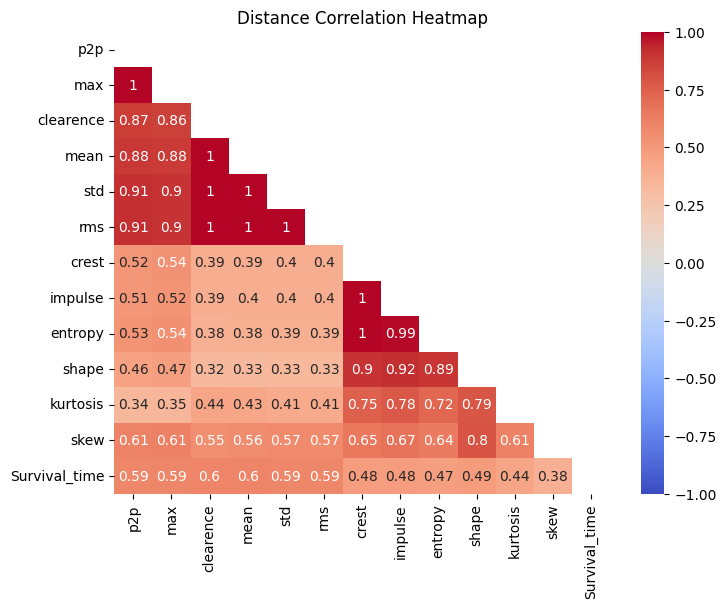

In [122]:
# Compute distance correlation matrix
correlation_matrix = np.zeros((len(X3.columns), len(X3.columns)))
for i in range(len(X3.columns)):
    for j in range(i+1, len(X3.columns)):
        feature1 = X3.iloc[:, i].values.reshape(-1, 1)
        feature2 = X3.iloc[:, j].values.reshape(-1, 1)
        NLcor = dcor.distance_correlation(feature1, feature2)
        correlation_matrix[i, j] = NLcor
        correlation_matrix[j, i] = NLcor

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1,
            xticklabels=X3.columns, yticklabels=X3.columns)
plt.title('Distance Correlation Heatmap')
plt.show()

# Report of performance

In [157]:
df_CI = pd.DataFrame(columns= ["Model", "CI score"])
df_B = pd.DataFrame(columns= ["Model", "Brier score"])

def plot_performance(last, model_name, CI_score, brier_score, df_CI, df_B):

    if last == True:
        _, ax = plt.subplots(figsize=(11, 6))
        sns.boxplot(x= "Model", y="CI score", data=df_CI, ax=ax)
        _, xtext = plt.xticks()
        for t in xtext:
            t.set_rotation("vertical")        

        _, ax = plt.subplots(figsize=(11, 6))
        sns.boxplot(x= "Model", y="Brier score", data=df_B, ax=ax)
        _, xtext = plt.xticks()
        for t in xtext:
            t.set_rotation("vertical")

        return df_CI, df_B
    else:
        temp_CI= {"Model": [], "CI score": []}
        temp_CI["Model"].append(model_name)
        temp_CI["CI score"].append(CI_score)
        temp_CI = pd.DataFrame.from_dict(temp_CI)
        df_CI = pd.concat([df_CI, temp_CI], ignore_index= True)

        temp_B= {"Model": [], "Brier score": []}
        temp_B["Model"].append(model_name)
        temp_B["Brier score"].append(brier_score)    
        temp_B = pd.DataFrame.from_dict(temp_B)
        df_B = pd.concat([df_B, temp_B], ignore_index= True)

        return df_CI, df_B


# Kaplan-meier survival curves

In [8]:
from lifelines import KaplanMeierFitter

In [9]:
km_sc= KaplanMeierFitter()
km_sc.fit(durations= X["Survival_time"], event_observed= X["Survival_time"])
km_sc.event_table



,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,40,40
17.3,2,2,0,0,40
19.3,3,3,0,0,38
20.3,1,1,0,0,35
23.3,2,2,0,0,34
64.9,1,1,0,0,32
66.9,1,1,0,0,31
67.9,3,3,0,0,30
70.9,1,1,0,0,27


In [10]:
km_sc.predict(11)
km_sc.survival_function_

,KM_estimate
timeline,
0.0,1.000
17.3,0.950
19.3,0.875
20.3,0.850
23.3,0.800
64.9,0.775
66.9,0.750
67.9,0.675
70.9,0.650


Text(0.5, 1.0, 'Kaplan Meier')

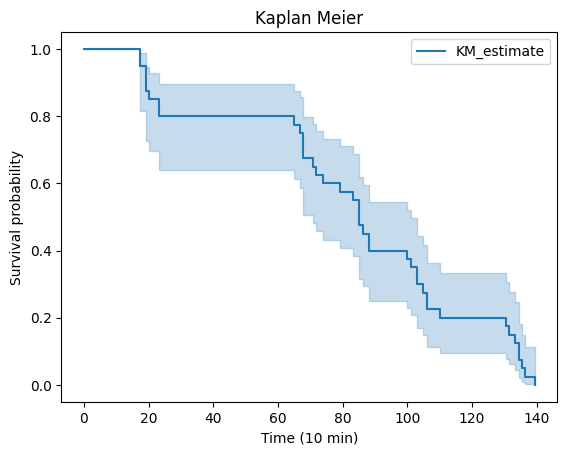

In [11]:
km_sc.plot()
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability")
plt.title("Kaplan Meier")

In [12]:
attrs = vars(km_sc)
print(', '.join("%s: %s" % item for item in attrs.items()))

alpha: 0.05, _class_name: KaplanMeierFitter, _label: KM_estimate, _censoring_type: CensoringType.RIGHT, durations: [ 67.9  67.9  71.9  73.9  64.9  66.9  67.9  70.9 134.4 135.4 136.4 139.4
 131.4 134.4 130.4 133.4 105.  106.  101.  103.  106.  110.  100.  103.
  86.2  85.2  85.2  88.2  85.2  88.2  79.2  83.2  17.3  19.3  19.3  23.3
  20.3  23.3  17.3  19.3], event_observed: [ 67  67  71  73  64  66  67  70 134 135 136 139 131 134 130 133 105 106
 101 103 106 110 100 103  86  85  85  88  85  88  79  83  17  19  19  23
  20  23  17  19], timeline: [  0.   17.3  19.3  20.3  23.3  64.9  66.9  67.9  70.9  71.9  73.9  79.2
  83.2  85.2  86.2  88.2 100.  101.  103.  105.  106.  110.  130.4 131.4
 133.4 134.4 135.4 136.4 139.4], entry: None, event_table:           removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0        40       40
17.3            2         2         0         0       40
19.3            

In [13]:
attrs = vars(cph_model)
print(', '.join("%s: %s" % item for item in attrs.items()))

alpha: 0.1, ties: breslow, n_iter: 100, tol: 1e-09, verbose: 0, _baseline_model: <sksurv.linear_model.coxph.BreslowEstimator object at 0x000001E5C76E0C70>, feature_names_in_: ['entropy' 'crest' 'shape' 'impulse'], n_features_in_: 4, coef_: [ 0.29071454 -0.5935022   0.27940733  0.56050702]


In [14]:
print (cph_surv_probs)

         0         1         2         3         4         5         6     
0   0.933153  0.899393  0.863765  0.863765  0.863765  0.827829  0.827829  \
1   0.933235  0.899515  0.863927  0.863927  0.863927  0.828029  0.828029   
2   0.923182  0.884707  0.844345  0.844345  0.844345  0.803895  0.803895   
3   0.920636  0.880970  0.839423  0.839423  0.839423  0.797855  0.797855   
4   0.951439  0.926545  0.899988  0.899988  0.899988  0.872887  0.872887   
5   0.919826  0.879782  0.837861  0.837861  0.837861  0.795939  0.795939   
6   0.920598  0.880914  0.839350  0.839350  0.839350  0.797765  0.797765   
7   0.920666  0.881013  0.839480  0.839480  0.839480  0.797925  0.797925   
8   0.933091  0.899302  0.863645  0.863645  0.863645  0.827680  0.827680   
9   0.922051  0.883046  0.842156  0.842156  0.842156  0.801208  0.801208   
10  0.920922  0.881390  0.839976  0.839976  0.839976  0.798532  0.798532   
11  0.919787  0.879725  0.837785  0.837785  0.837785  0.795847  0.795847   

         7 

In [108]:
print (cph_surv_probs)

         0         1         2         3         4         5         6     
0   0.905606  0.872196  0.872196  0.872196  0.836826  0.836826  0.836826  \
1   0.905989  0.872705  0.872705  0.872705  0.837462  0.837462  0.837462   
2   0.889993  0.851525  0.851525  0.851525  0.811083  0.811083  0.811083   
3   0.866952  0.821272  0.821272  0.821272  0.773746  0.773746  0.773746   
4   0.939428  0.917436  0.917436  0.917436  0.893811  0.893811  0.893811   
5   0.881532  0.840381  0.840381  0.840381  0.797282  0.797282  0.797282   
6   0.883588  0.843085  0.843085  0.843085  0.800626  0.800626  0.800626   
7   0.883559  0.843047  0.843047  0.843047  0.800578  0.800578  0.800578   
8   0.905521  0.872082  0.872082  0.872082  0.836684  0.836684  0.836684   
9   0.887179  0.847814  0.847814  0.847814  0.806481  0.806481  0.806481   
10  0.884344  0.844080  0.844080  0.844080  0.801857  0.801857  0.801857   
11  0.884603  0.844422  0.844422  0.844422  0.802280  0.802280  0.802280   

         7 

Text(0.5, 1.0, 'Cox PH')

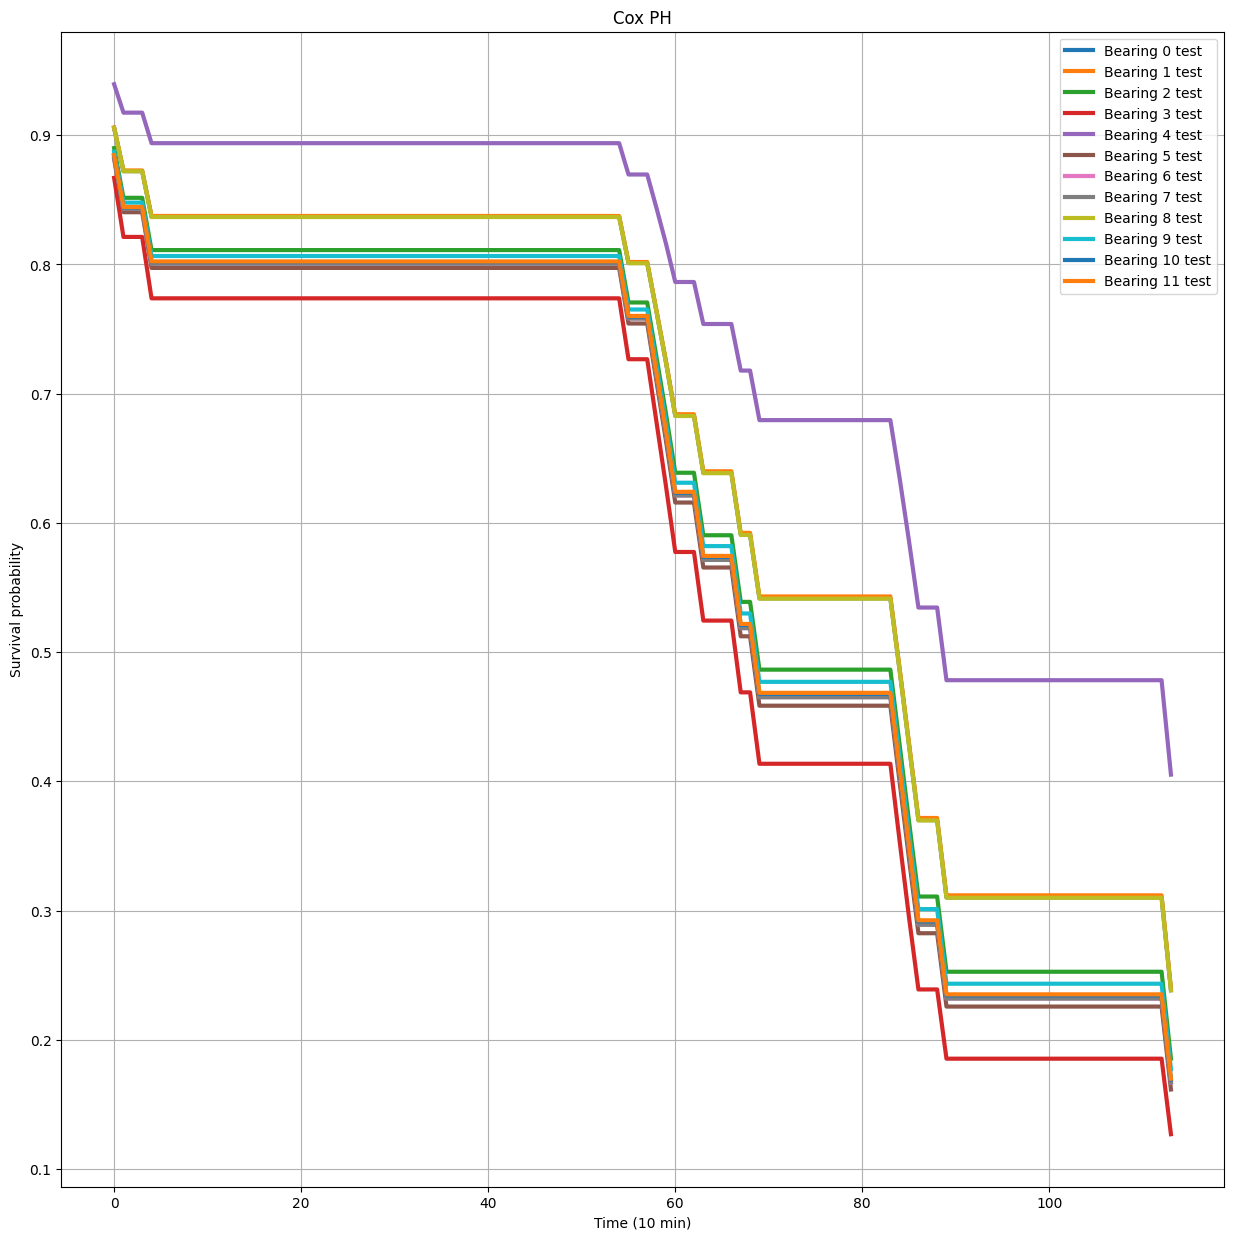

In [106]:
surv_label= []
for i in range (0, len (y_test) +1):
    surv_label.append('Bearing ' + str(i) + ' test')

cph_surv_probs.T.plot(figsize=(15, 15), linewidth=3)
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability")
plt.grid()
plt.legend(surv_label)
plt.title("Cox PH")

In [64]:
from lifelines.utils import survival_table_from_events
new_probs= cph_surv_probs.T
print (new_probs)
event_table= survival_table_from_events(X['Survival_time'].astype('int'),X['Event'])
print (event_table.index)

           0         1         2         3         4         5         6    
0    0.933153  0.933235  0.923182  0.920636  0.951439  0.919826  0.920598  \
1    0.899393  0.899515  0.884707  0.880970  0.926545  0.879782  0.880914   
2    0.863765  0.863927  0.844345  0.839423  0.899988  0.837861  0.839350   
3    0.863765  0.863927  0.844345  0.839423  0.899988  0.837861  0.839350   
4    0.863765  0.863927  0.844345  0.839423  0.899988  0.837861  0.839350   
..        ...       ...       ...       ...       ...       ...       ...   
108  0.325591  0.326059  0.273531  0.261549  0.446033  0.257842  0.261374   
109  0.325591  0.326059  0.273531  0.261549  0.446033  0.257842  0.261374   
110  0.325591  0.326059  0.273531  0.261549  0.446033  0.257842  0.261374   
111  0.325591  0.326059  0.273531  0.261549  0.446033  0.257842  0.261374   
112  0.251141  0.251586  0.202650  0.191775  0.370033  0.188433  0.191617   

           7         8         9         10        11  
0    0.920666  0.93

In [89]:
filter_arr = event_table.index < 129
event_table_idx= event_table.index
new_event_table = event_table_idx[filter_arr]
print (event_table_idx)

minn= 0
maxn= 1

result= []
survival_functions= []

for i in range (0, len (y_test)):

    survival_function = cph_surv_probs.T[i][new_event_table]

    # Calculate the Greenwood formula
    n_events = event_table.iloc[:, 0]
    variance_estimate = np.cumsum(event_table['observed'] / (event_table['at_risk'] * (event_table['at_risk'] - event_table['observed'])))

    # Calculate the confidence intervals using the Greenwood formula
    z = 1.96  # Z-value for 95% confidence interval
    lower_bound = np.clip(survival_function * np.exp(-z * np.sqrt(variance_estimate / (survival_function ** 2))), minn, maxn)

    upper_bound = np.clip(survival_function * np.exp(z * np.sqrt(variance_estimate / (survival_function ** 2))), minn, maxn)

    # Create a DataFrame with the survival function and confidence intervals
    result_temp = pd.DataFrame({'Survival Function': survival_function,
                        'Lower Bound': lower_bound, 'Upper Bound': upper_bound})

    result_temp = result_temp.dropna()

    survival_functions.append(survival_function)    
    result.append(result_temp)

# Print the result
print(result)

Index([  0.0,  17.0,  19.0,  20.0,  23.0,  64.0,  66.0,  67.0,  70.0,  71.0,
        73.0,  79.0,  83.0,  85.0,  86.0,  88.0, 100.0, 101.0, 103.0, 105.0,
       106.0, 110.0, 130.0, 131.0, 133.0, 134.0, 135.0, 136.0, 139.0],
      dtype='float64', name='event_at')
[          Survival Function  Lower Bound  Upper Bound
event_at                                             
0.0                0.933153     0.933153     0.933153
17.0               0.827829     0.779663     0.878971
19.0               0.827829     0.742654     0.922773
20.0               0.827829     0.728040     0.941295
23.0               0.827829     0.702810     0.975087
64.0               0.638769     0.505763     0.806753
66.0               0.590617     0.448635     0.777534
67.0               0.542014     0.382826     0.767396
70.0               0.542014     0.382826     0.767396
71.0               0.542014     0.372324     0.789042
73.0               0.542014     0.362052     0.811428
79.0               0.542014     

In [77]:
print (result.index)

Index([  0.0,  17.0,  19.0,  20.0,  23.0,  64.0,  66.0,  67.0,  70.0,  71.0,
        73.0,  79.0,  83.0,  85.0,  86.0,  88.0, 100.0, 101.0, 103.0, 105.0,
       106.0, 110.0],
      dtype='float64', name='event_at')


Text(0.5, 1.0, 'Cox PH')

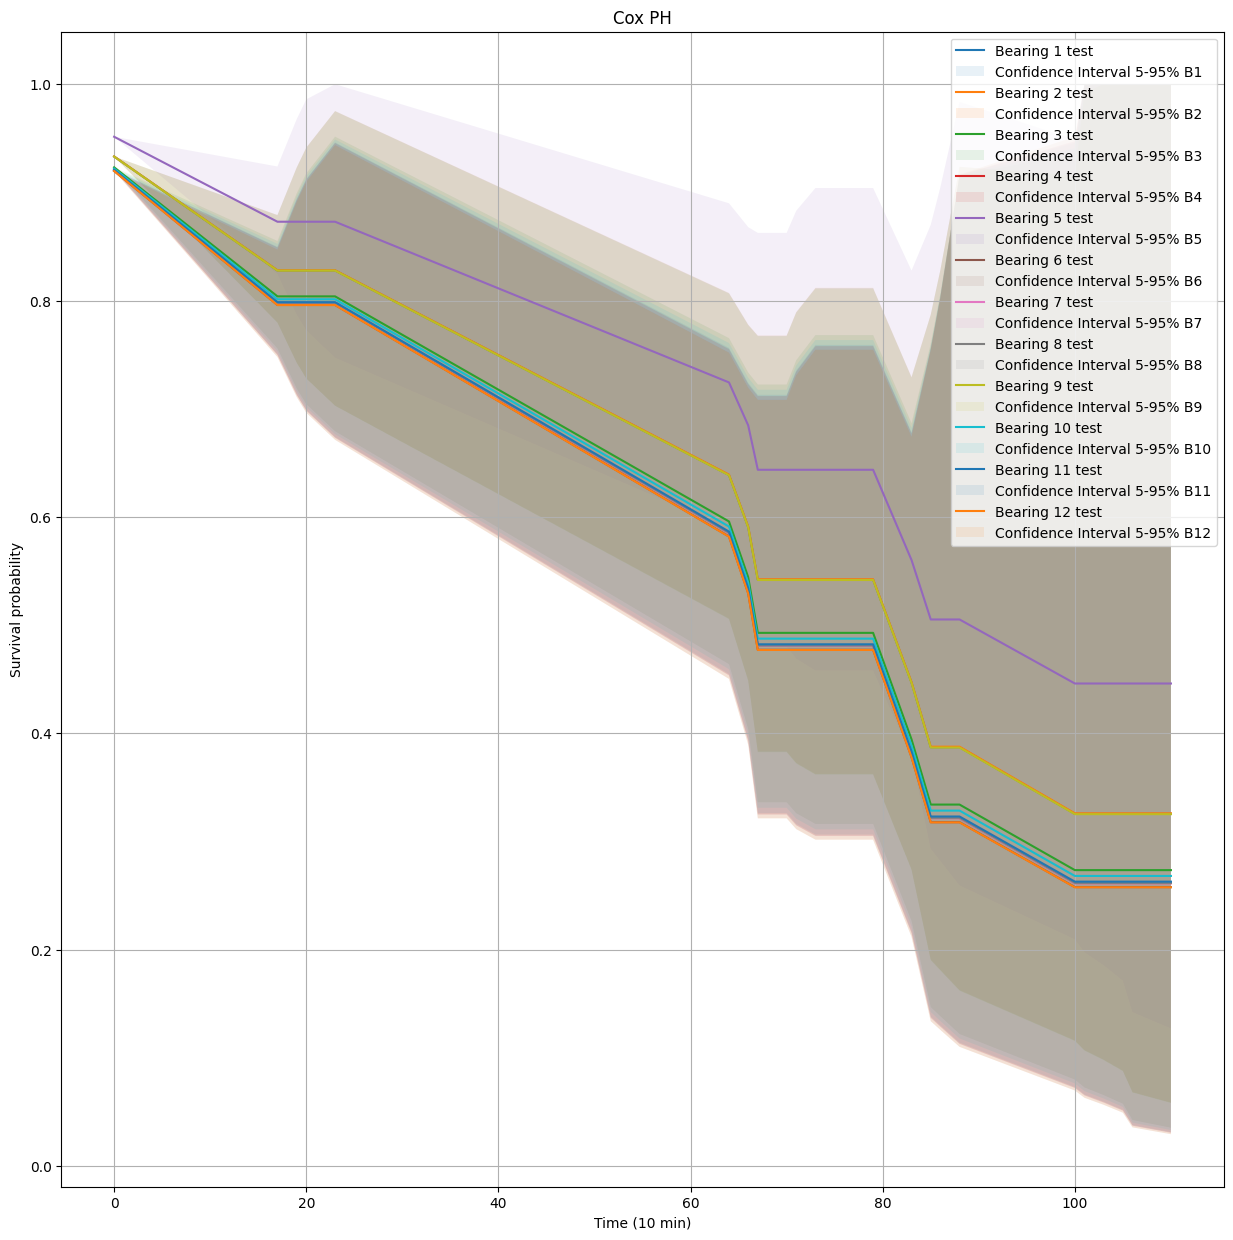

In [95]:
surv_label = []
for i in range (1, len (y_test) + 2):
    surv_label.append('Bearing ' + str(i) + ' test')
    surv_label.append('Confidence Interval 5-95% ' + 'B' + str(i))

i= 0
for sf in survival_functions:
    sf.plot(figsize=(15, 15))
    plt.fill_between(result[i].index, (result[i]["Lower Bound"].values), (result[i]["Upper Bound"].values), alpha=.1)
    i += 1
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability")
plt.legend(surv_label)
plt.grid()
plt.title("Cox PH")

# Cox PH assumption and recurrent events

In [158]:
from lifelines import CoxPHFitter

In [164]:
cph = CoxPHFitter()

cph.fit(X, duration_col= "Survival_time", event_col= "Event")

<lifelines.CoxPHFitter: fitted with 40 total observations, 10 right-censored observations>


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1907)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2031)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2190)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2817)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7808)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6249)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3409)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2497)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1516)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1039)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3841)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5010)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5851)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7015)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6909)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8158)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2668)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1912)'>],
 [<Axes: xlabel='rank-transformed tim

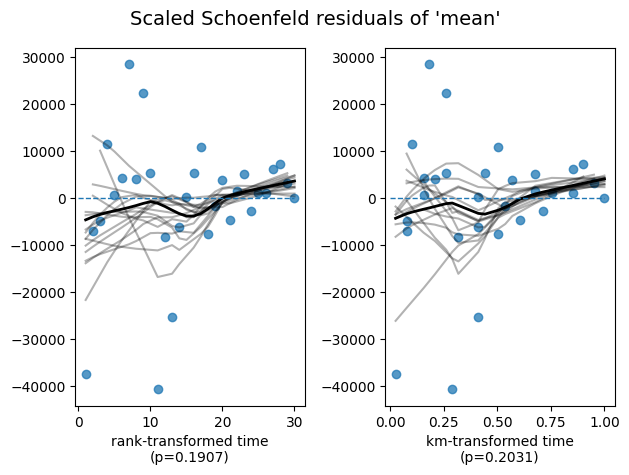

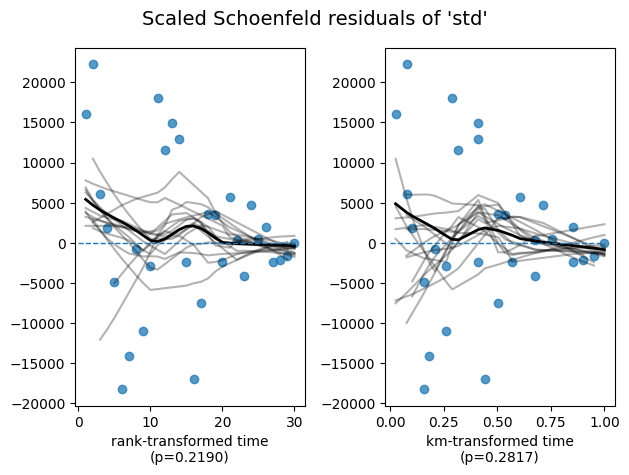

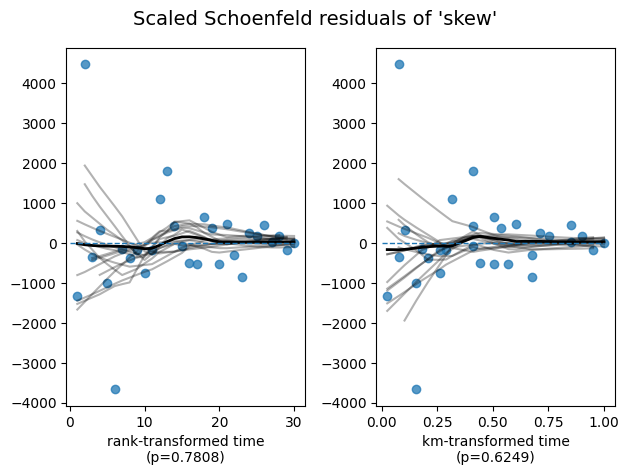

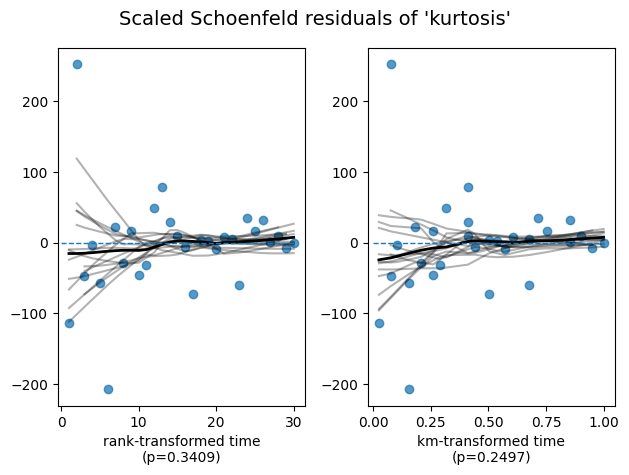

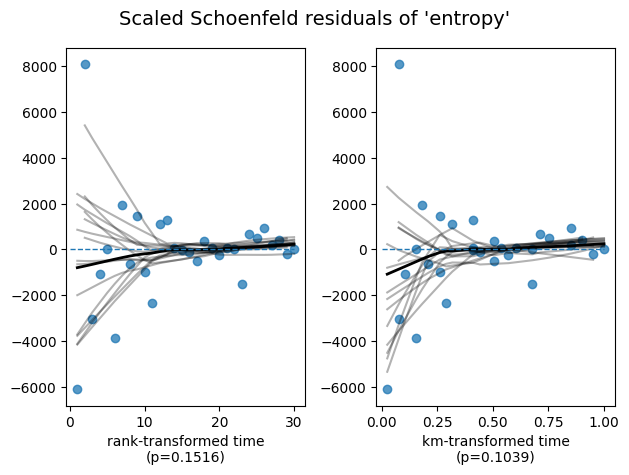

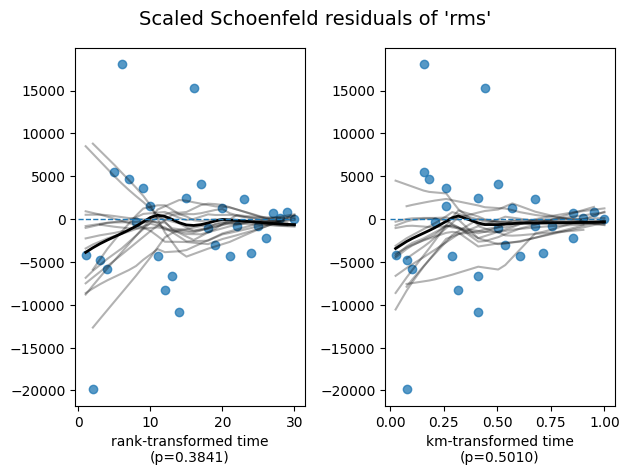

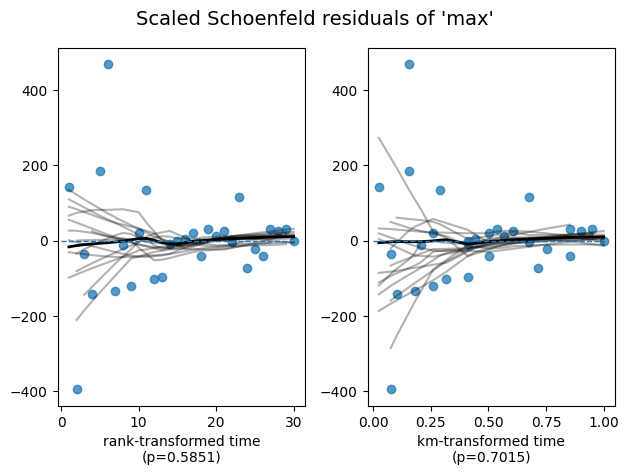

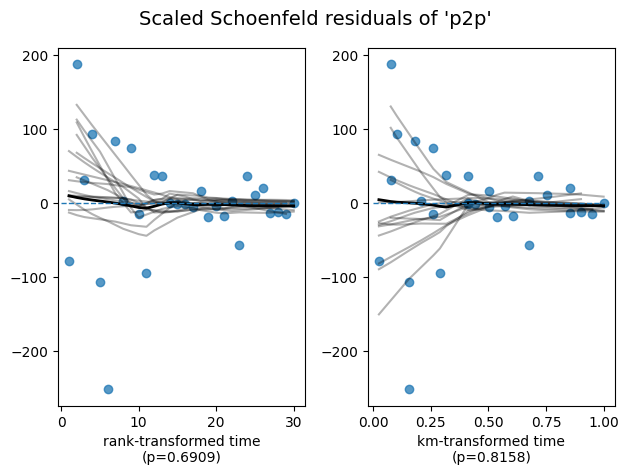

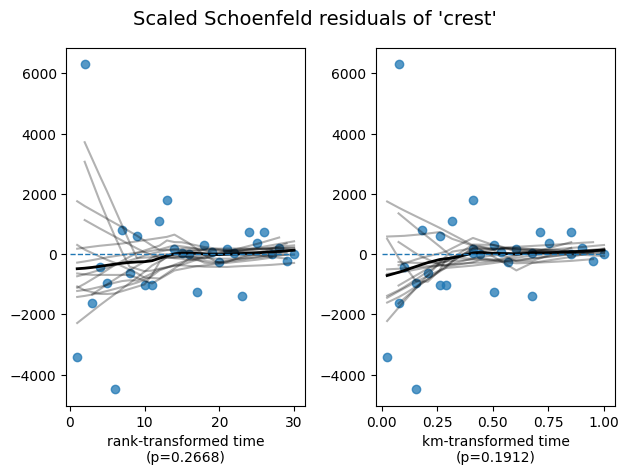

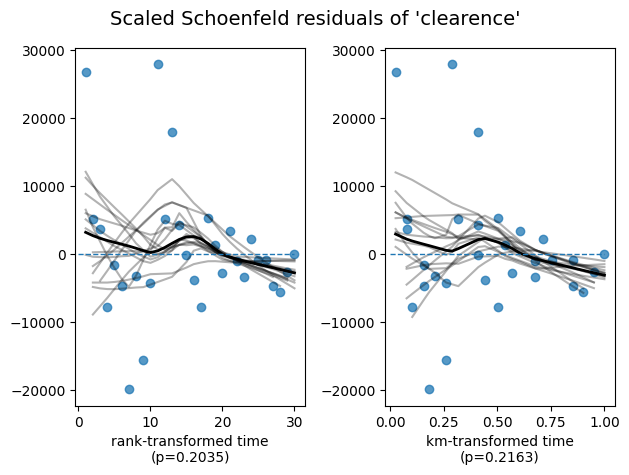

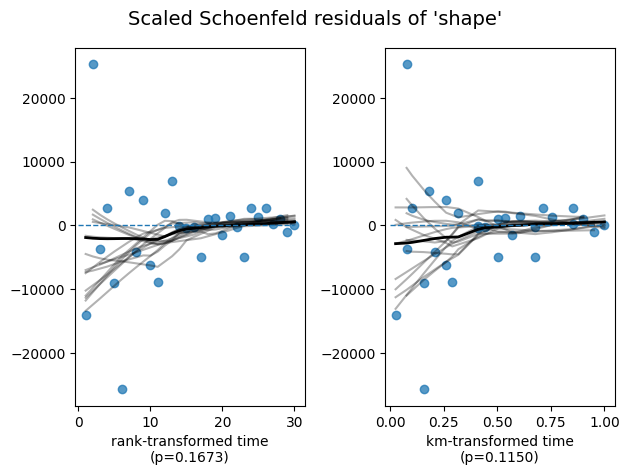

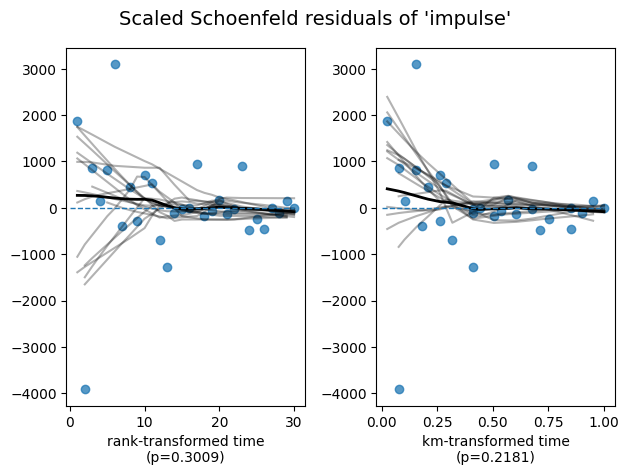

In [165]:
cph.check_assumptions(X, p_value_threshold=0.05, show_plots=True)

In [167]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, X, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 40 total observations, 10 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
clearence            1.62 0.20      2.30
crest                1.23 0.27      1.91
entropy              2.06 0.15      2.72
impulse              1.07 0.30      1.73
kurtosis             0.91 0.34      1.55
max                  0.30 0.59      0.77
mean                 1.71 0.19      2.39
p2p                  0.16 0.69      0.53
rms                  0.76 0.38      1.38
shape                1.91 0.17      2.58
skew                 0.08 0.78      0.36
std                  1.51 0.22      2.19